<a href="https://colab.research.google.com/github/augustlidfeldt/EDAN70/blob/main/Alpha_Release/Alpha1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer learning


Transfer learning has been applied by using VGG16 model's top layers and adding new fully connected layers and a binary softmax layer for our three-class classification task.

In the architecture the following layers to the VGG16 model

x = Flatten (name='flatten') (output_vgg16_conv)

x = Dense (64, activation='relu', name='fc1')(x)

x = Dense (64, activation='relu', name='fc2')(x)

x = Dense (3, activation='softmax', name='predictions')(x)


## Prediciting tissue damage from test images

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                1605696   
_________________________________________________________________
fc2 (Dense)                  (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 3)                 195       
Total params: 16,324,739
Trainable params: 1,610,051
Non-trainable params: 14,714,688
__________________________________

FileNotFoundError: ignored

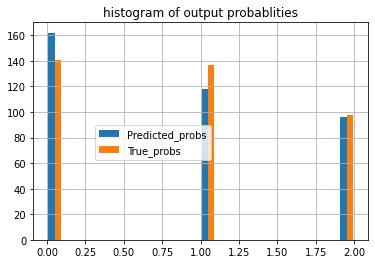

In [4]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cv2
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Model
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

## Here the saved .h5 weights are used for predicting the labels of validation dataset
## The results are presented as a dataframe in a table
## Different models on different datasets are presented here##
## Models:
## 1) VGG16+fc-layers

validation_DATA_PATH = 'test/'
input_shape = (224,224,3)
validation_images = glob.glob(validation_DATA_PATH+'*.tif')
n_v= len(validation_images) 
validation_samples = np.zeros((n_v, input_shape[0], input_shape[1], 3), dtype=np.float32)
validation_label = np.zeros((n_v,), int)


###Reading true labels#######################################       
with open('test_newlabels.txt','r') as f:
    for ctr,line in zip(range(n_v),f):
        validation_samples[ctr,:,:,:] = cv2.imread(validation_DATA_PATH+(line.split()[0]))
        la = float(line.split()[1])
        validation_label[ctr]   = la
        
for i in range(n_v):
    mod_img = validation_samples[i,:, :].astype(np.float32)
    validation_samples[i, :, :, :] = mod_img

#print(samples.dtype)
validation_samples = np.clip(validation_samples, 0, 255)    
validation_samples /= 255
validation_samples -= 0.5

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                1605696   
_________________________________________________________________
fc2 (Dense)                  (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 3)                 195       
Total params: 16,324,739
Trainable params: 1,610,051
Non-trainable params: 14,714,688
__________________________________

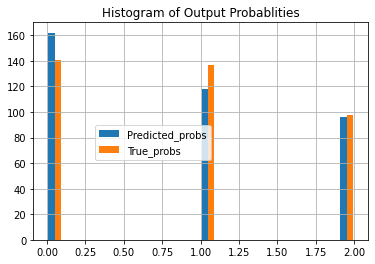

[[119  43   0]
 [ 20  93   5]
 [  2   1  93]]
              precision    recall  f1-score   support

           0       0.84      0.73      0.79       162
           1       0.68      0.79      0.73       118
           2       0.95      0.97      0.96        96

    accuracy                           0.81       376
   macro avg       0.82      0.83      0.82       376
weighted avg       0.82      0.81      0.81       376



In [5]:
# Loading VGG16 and the top layers
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)   
#input format
keras_input = Input(shape=(224,224,3), name = 'image_input')
#Use the generated model 
output_vgg16_conv = model_vgg16_conv(keras_input)

for layer in model_vgg16_conv.layers:
    layer.trainable = False
layer_type = 'relu'
num_classes = 3

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(64, activation=layer_type, name='fc1')(x)
x = Dense(64, activation=layer_type, name='fc2')(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

#Create your own model 
pretrained_model = Model(inputs=keras_input, outputs=x)
pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pretrained_model.summary()
pretrained_model.load_weights('alpha_weights.h5')
preds = pretrained_model.predict(validation_samples)

try:
  if not os.path.exists('results'):
    os.makedirs('results')
except:
  print("Results dir exists")

pred_max = []
for i in range(len(preds)):
  pred_max.append(preds[i].argmax())

################################################################
### The output probablity of validation data set
y_prob     = np.zeros([len(validation_label)])
y_prob     = preds[:,1].reshape(len(validation_label))

fig4 = plt.figure()
plt.hist([validation_label,np.array(pred_max)],20,label=['Predicted_probs','True_probs'])
plt.title('Histogram of Output Probablities')
fig4.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5))
plt.grid()
plt.savefig('Prob_histogram.png')
plt.show()

cfm = confusion_matrix(validation_label,np.array(pred_max))
print(cfm)

cr = classification_report(validation_label,np.array(pred_max))
print(cr)

In [31]:
# Make prediction on single file
file_index = 50
correct_label = validation_label[file_index]

labels_single = ['Low tissue damage','Medium tissue damage','Severe tissue damage'] 

print("Predicted label: " + labels_single[pred_max[file_index]])
print("Actual label: " + labels_single[correct_label])


Predicted label: Medium tissue damage
Actual label: Medium tissue damage
